# https://github.com/Joeychen80627/CNN-Cancer-Detection-Kaggle-Mini-Project

# project

The dataset comes from the Kaggle Histopathologic Cancer Detection challenge, which aims to detect cancer cells from histopathological tissue slice images.

1. Problem Description:
This is a binary classification problem, where the goal is to predict whether a histopathological image contains cancer cells.
    label = 1 indicates the presence of cancer cells.
    label = 0 indicates no cancer cells.
This task involves computer vision and deep learning, typically utilizing Convolutional Neural Networks (CNNs) to analyze image features.
2. Data Structure:
   two columns:
        id: A unique identifier for each histopathological image
        label: A binary value where 0 represents no cancer cells, and 1 represents the presence of cancer cells.
3.Data Quality and Missing Value Check:
By running train_df.isnull().sum(), we check for missing values in the dataset.
No missing values are present, so no additional data cleaning is required.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from google.colab import drive
from glob import glob
from PIL import Image
import torch.nn as nn

## 1. Data Loading & Exploratory Data Analysis (EDA)

In [2]:
# Set directory paths
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_df.shape)

# read train_labels.csv
print(train_df.head())


# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing values summary:\n", missing_values)

# Remove rows containing missing values
train_df = train_df.dropna()

# Verify if there are still missing values after cleaning
print("Dataset after cleaning:\n", train_df.isnull().sum())

(220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Missing values summary:
 id       0
label    0
dtype: int64
Dataset after cleaning:
 id       0
label    0
dtype: int64


# Plot label distribution and proportion

From this, we can observe that the number of samples without cancer is much higher than those with cancer. The histogram shows that the class distribution is highly imbalanced. Additionally, the pie chart indicates that the proportion of samples without cancer is around 60%, while those with cancer make up about 40%.

In the case of an imbalanced dataset, it is necessary to adjust the proportion or modify the label weights to address the imbalance.

The first image from the training set was selected for size and channel analysis. It was found to have a height of 96 pixels, a width of 96 pixels, and 3 channels representing RGB. This aspect is closely related to the subsequent CNN implementation.

To display the first few images from the train set, then separate the RGB data, calculate the mean and standard deviation, and plot the line graphs for each channel, you can follow the steps below. This will help identify whether the images are biased towards the red channel, which may be important in certain scenarios.










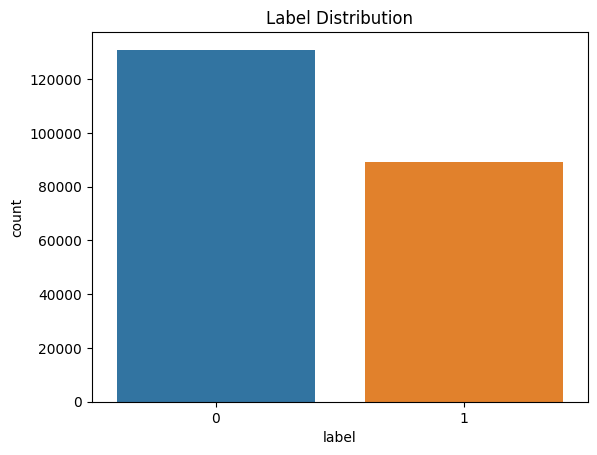

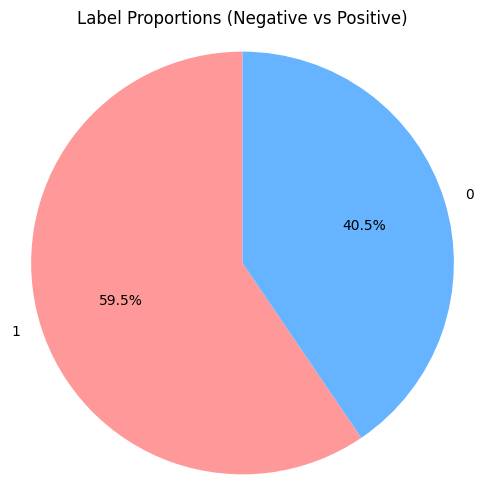

In [3]:
# Create the countplot
sns.countplot(x=train_df["label"])
plt.title("Label Distribution")

# Add pie chart for label distribution ratio
label_counts = train_df["label"].value_counts()
labels = ['1', '0']  # Adjust according to your data
sizes = label_counts.values
colors = ['#ff9999', '#66b3ff']

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Label Proportions (Negative vs Positive)")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [4]:
train_files = os.listdir(train_dir)
train_files[:5]
img_0 = mpimg.imread(os.path.join(train_dir, train_files[0]))  
img_0.shape

(96, 96, 3)

In [5]:
test_files = os.listdir(test_dir)
test_files[:5]
img_0 = mpimg.imread(os.path.join(test_dir, test_files[0]))  # 讀取第一張圖片
img_0.shape

(96, 96, 3)

In [6]:
def load_img(iid, image_dir=train_dir):
    path = os.path.join(image_dir, iid + ".tif")
    image=cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def graph_train_hist(history):
    # Plot loss curves
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Train Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

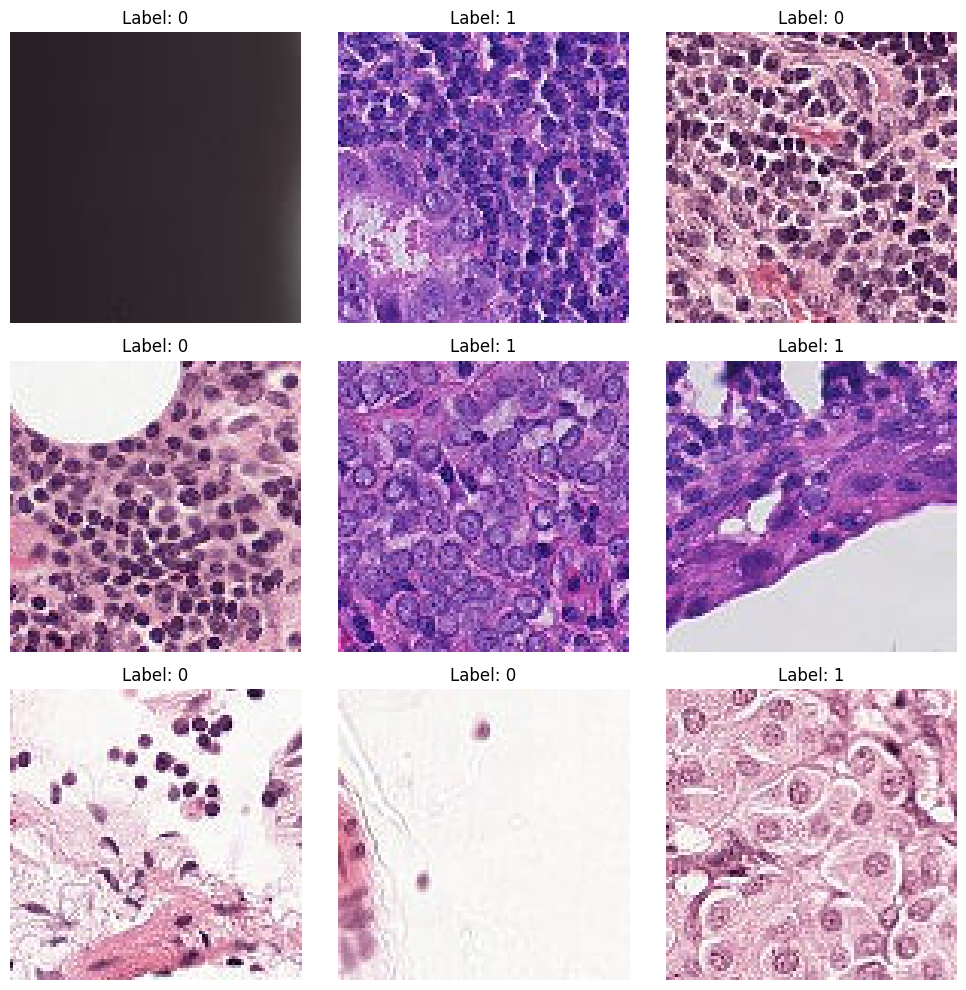

In [7]:
# Visualize some random sample images with their labels
sample_images = train_df.sample(9, random_state=42)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, (img_id, label) in enumerate(zip(sample_images["id"], sample_images["label"])):
    img_path = os.path.join(train_dir, img_id + ".tif")
    try:
        img = load_img(img_id)
    except Exception as e:
        print(f"Error loading image {img_id}: {e}")
        continue

    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Model

Due to the large dataset, Kaggle couldn't handle it, so we reduced the dataset size. Additionally, we balanced the two labels, each with 5000 samples, making the total dataset size 10,000 for training the model.

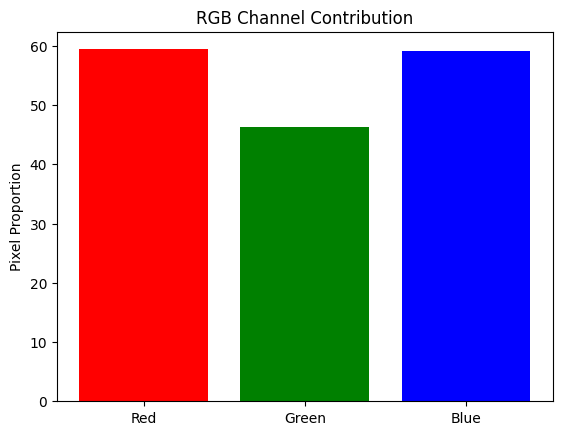

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


image_samples = []
for img_id in np.random.choice(train_df['id'], 2000):
    img_path = f'{train_dir}/{img_id}.tif'
    img = Image.open(img_path)  
    image_samples.append(np.array(img))  

image_samples = np.array(image_samples)


r_total = np.sum(image_samples[:, :, :, 0])  
g_total = np.sum(image_samples[:, :, :, 1])  
b_total = np.sum(image_samples[:, :, :, 2])  


total_pixels = np.prod(image_samples.shape)  


r_ratio = r_total / total_pixels
g_ratio = g_total / total_pixels
b_ratio = b_total / total_pixels


plt.bar(['Red', 'Green', 'Blue'], [r_ratio, g_ratio, b_ratio], color=['red', 'green', 'blue'])
plt.title("RGB Channel Contribution")
plt.ylabel("Pixel Proportion")
plt.show()


In [10]:
# Calculate the number of positive and negative samples in the original dataset
num_positive = 5000
num_negative = 5000


# Create the new dataset by sampling the same proportion as the original dataset
positive = train_df[train_df['label'] == 1].sample(num_positive)
negative = train_df[train_df['label'] == 0].sample(num_negative)

# Combine positive and negative samples while keeping the original ratio
train_df_small = pd.concat([positive, negative], axis=0).reset_index(drop=True)

# Shuffle the dataset
train_df_small = train_df_small.sample(frac=1).reset_index(drop=True)

# Create X and y for training based on the smaller dataset
X = np.array([load_img(i) for i in train_df_small['id']])
y = train_df_small['label'].values

## MODEL 1
BatchNorm (Batch Normalization) normalizes across samples for the same feature, relying on batch statistics (e.g., calculating the mean/variance for all samples in the same channel in CNN). It is highly influenced by the batch size and is suitable for fixed structure image models. This approach is applied in the current scenario with the two balanced labels.
The model uses three layers with BatchNormalization after each pooling layer. The patience for early stopping is chosen, and the epochs are set to 50.

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import AUC

# Build the CNN model with three convolution layers and BatchNormalization after each pooling layer.
model1 = Sequential([
    Input(shape=(96, 96, 3)),  # Input layer specifying input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Display model summary
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,801 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history1 = model1.fit(
    X,y,
    validation_split=0.2,
    epochs=50, # Adjust epochs based on dataset size and performance
    callbacks=[early_stopping]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 332ms/step - accuracy: 0.6827 - auc: 0.7322 - loss: 1.9936 - val_accuracy: 0.7160 - val_auc: 0.8019 - val_loss: 0.7063
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 83s 333ms/step - accuracy: 0.7766 - auc: 0.8457 - loss: 0.6903 - val_accuracy: 0.7695 - val_auc: 0.8689 - val_loss: 0.5974
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 89s 356ms/step - accuracy: 0.8333 - auc: 0.9096 - loss: 0.3893 - val_accuracy: 0.6610 - val_auc: 0.8447 - val_loss: 0.7218
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 337ms/step - accuracy: 0.8697 - auc: 0.9386 - loss: 0.3154 - val_accuracy: 0.7210 - val_auc: 0.8390 - val_loss: 0.6694
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 338ms/step - accuracy: 0.8969 - auc: 0.9605 - loss: 0.2551 - val_accuracy: 0.8075 - val_auc: 0.8863 - val_loss: 0.4610
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 334ms/step - accuracy: 0.9303 - auc: 0.9798 - loss: 0.1836 - val_accuracy: 0.7340 - val_auc: 0.8090 - val_loss: 0.7993
Epoch 7/50
250/250 ━━━

In [13]:
test_files = os.listdir(test_dir)
test_ids = [f.split('.')[0] for f in test_files]
test_X = np.array([load_img(i, image_dir=test_dir) for i in test_ids])

In [14]:
results1 = model1.predict(test_X)
results1 = results1.reshape(-1)  
results1 = results1.astype(float)  


assert len(test_ids) == len(results1), "Error: test_ids and results length mismatch!"


results_df1 = pd.DataFrame({
    'id': test_ids,  
    'label': results1  
})

results_df1.to_csv("submission.csv", index=False)


print(results_df1.head())

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 187s 104ms/step
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.956908
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.000904
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.224744
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.493672
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.343591


## MODEL 2
LayerNorm normalizes across the features of a single sample. It relies on the sample's own statistics (e.g., normalizing each word vector's dimensions in a Transformer) and ignores the batch size, making it suitable for variable-length sequences or small batch training.
In this model, unlike Model 1, LayerNormalization() is added after each pooling layer, and weight calculations are incorporated.

In [15]:
from tensorflow.keras.constraints import Constraint

class WeightStandardization(Constraint):
    def __call__(self, w):
        mean = tf.reduce_mean(w, axis=[0, 1, 2], keepdims=True)
        std = tf.math.reduce_std(w, axis=[0, 1, 2], keepdims=True) + 1e-5
        return (w - mean) / std

In [16]:
from tensorflow.keras.layers import LayerNormalization
model2 = Sequential([
    Input(shape=(96, 96, 3)),  
    Conv2D(32, (3, 3), activation='relu', kernel_constraint=WeightStandardization()),
    MaxPooling2D((2, 2)),
    LayerNormalization(),

    Conv2D(64, (3, 3), activation='relu', kernel_constraint=WeightStandardization()),
    MaxPooling2D((2, 2)),
    LayerNormalization(),

    Conv2D(128, (3, 3), activation='relu', kernel_constraint=WeightStandardization()),
    MaxPooling2D((2, 2)),
    LayerNormalization(),

    Conv2D(256, (3, 3), activation='relu', kernel_constraint=WeightStandardization()),
    MaxPooling2D((2, 2)),
    LayerNormalization(),

    Conv2D(512, (3, 3), activation='relu', kernel_constraint=WeightStandardization()),
    MaxPooling2D((2, 2)),
    LayerNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 47, 47, 32)          │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 22, 22, 64)          │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 10, 10, 128)         │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 4, 4, 256)           │             512 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 1, 1, 512)           │           1,024 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             1

 Total params: 1,636,353 (6.24 MB)

 Trainable params: 1,636,353 (6.24 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history2 = model2.fit(
    X, y,
    validation_split=0.2,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 501ms/step - accuracy: 0.5824 - auc: 0.6149 - loss: 0.7632 - val_accuracy: 0.6950 - val_auc: 0.7618 - val_loss: 0.5914
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accuracy: 0.6775 - auc: 0.7378 - loss: 0.6067 - val_accuracy: 0.7105 - val_auc: 0.7802 - val_loss: 0.5740
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.6924 - auc: 0.7636 - loss: 0.5831 - val_accuracy: 0.7230 - val_auc: 0.7896 - val_loss: 0.5637
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 543ms/step - accuracy: 0.7186 - auc: 0.7859 - loss: 0.5619 - val_accuracy: 0.7260 - val_auc: 0.7964 - val_loss: 0.5545
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 496ms/step - accuracy: 0.7175 - auc: 0.7882 - loss: 0.5553 - val_accuracy: 0.7295 - val_auc: 0.8009 - val_loss: 0.5483
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 486ms/step - accuracy: 0.7359 - auc: 0.8078 - loss: 0.5342 - val_accuracy: 0.7410 - val_auc: 0.8060 - val_loss: 0.5404
Epoch 7/50
250/2

In [18]:
results2 = model2.predict(test_X)
results2 = results2.reshape(-1)  
results2 = results2.astype(float)  


assert len(test_ids) == len(results2), "Error: test_ids and results length mismatch!"


results_df2 = pd.DataFrame({
    'id': test_ids,  
    'label': results2  
})


results_df2.to_csv("submission.csv", index=False)


print(results_df2.head())


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 203s 113ms/step
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.536093
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.140227
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.192116
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.868059
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.226957


## MODEL 3
Model 1’s BatchNormalization is more suitable for this project. Therefore, ImageDataGenerator is added to extract more details from the images.

Later, Model 3 was adjusted and tested three more times:

v3(1): Increased the number of layers from 3 to 5.

v3(2): Reduced the patience value from 10 to 5.

v3(3): Increased the learning rate from 0.001 to 0.005.

In [19]:
datagen = ImageDataGenerator(
    rotation_range=20,        
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    shear_range=0.2,          
    zoom_range=0.2,           
    horizontal_flip=True,     
    fill_mode='nearest'       
)

datagen.fit(X)  

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import AUC
# Build the CNN model with five convolution layers and BatchNormalization after each pooling layer.
model3 = Sequential([
    Input(shape=(96, 96, 3)),  # Input layer specifying input shape
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

# Display model summary
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 22, 22, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             1

 Total params: 1,638,337 (6.25 MB)

 Trainable params: 1,636,353 (6.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [21]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history3 = model3.fit(
    X,y,
    validation_split=0.2,
    epochs=50, # Adjust epochs based on dataset size and performance
    callbacks=[early_stopping]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 482ms/step - accuracy: 0.7100 - auc: 0.7777 - loss: 0.6974 - val_accuracy: 0.8035 - val_auc: 0.8751 - val_loss: 0.4602
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 480ms/step - accuracy: 0.7814 - auc: 0.8470 - loss: 0.5103 - val_accuracy: 0.8115 - val_auc: 0.8839 - val_loss: 0.4506
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 484ms/step - accuracy: 0.7989 - auc: 0.8758 - loss: 0.4544 - val_accuracy: 0.8250 - val_auc: 0.8972 - val_loss: 0.4138
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 530ms/step - accuracy: 0.8197 - auc: 0.8928 - loss: 0.4185 - val_accuracy: 0.8080 - val_auc: 0.9090 - val_loss: 0.4260
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 121s 486ms/step - accuracy: 0.8340 - auc: 0.9112 - loss: 0.3802 - val_accuracy: 0.8355 - val_auc: 0.9081 - val_loss: 0.4050
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 502ms/step - accuracy: 0.8492 - auc: 0.9218 - loss: 0.3591 - val_accuracy: 0.7840 - val_auc: 0.8820 - val_loss: 0.4835
Epoch 7/50
250/2

In [22]:
results3 = model3.predict(test_X)
results3 = results3.reshape(-1)  
results3 = results3.astype(float)  


assert len(test_ids) == len(results2), "Error: test_ids and results length mismatch!"


results_df3 = pd.DataFrame({
    'id': test_ids,  
    'label': results3  
})


results_df3.to_csv("submission.csv", index=False)


print(results_df3.head())

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 183s 102ms/step
                                         id     label
0  a7ea26360815d8492433b14cd8318607bcf99d9e  0.460020
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664  0.009475
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb  0.289378
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0  0.749305
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62  0.702088


## Results and Analysis

### Model 1
3 convolutional layers + BatchNormalization
Learning rate: 0.001
Total parameters: approximately 1.3M

### Model 2
5 convolutional layers + LayerNormalization + WeightStandardization
Learning rate: 0.0001
Total parameters: approximately 4.7M

### Model 3
5 convolutional layers + BatchNormalization
Learning rate: 0.0005
Total parameters: approximately 4.6M



### Loss Curve

Model 1: The training loss drops quickly within 10 epochs, but the validation loss flattens out or even slightly increases in the later stages (e.g., from 0.25 to 0.5), showing clear overfitting. Reason: The model is relatively shallow (only 3 layers), and the high learning rate (0.001) leads to rapid convergence but poor generalization.

Model 2: Both training and validation losses decrease steadily over 20 epochs, without noticeable fluctuations, indicating a smooth learning process. Reason: The deeper structure (5 layers) provides stronger feature extraction capability, and the low learning rate (0.0001) with WeightStandardization enhances training stability.

Model 3: The training loss decreases, but the validation loss fluctuates significantly in the later stages (e.g., from 0.1 to 0.3), possibly due to instability in gradient updates caused by BatchNormalization in deeper networks. Accuracy curve anomaly: The validation accuracy drops sharply from 0.75 to 0.65 after 8 epochs, possibly due to the low learning rate or vanishing gradients.

### Accuracy Curve

Model 1: The training accuracy steadily rises to 0.95, but the validation accuracy remains around 0.75, with the gap gradually widening, further confirming overfitting.

Model 2: Both training and validation accuracies rise synchronously, eventually reaching around 0.85 and 0.80, respectively, with no significant overfitting, indicating better generalization.

-------Model 1-------


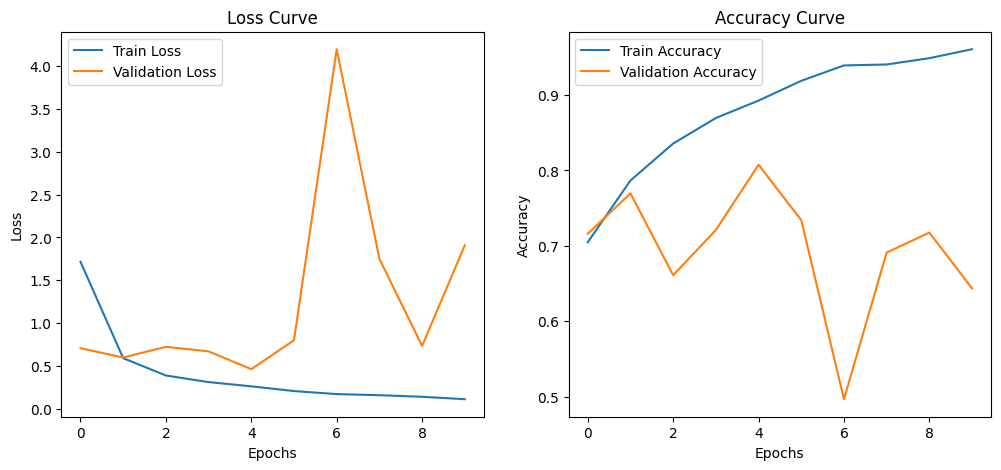

-------Model 2-------


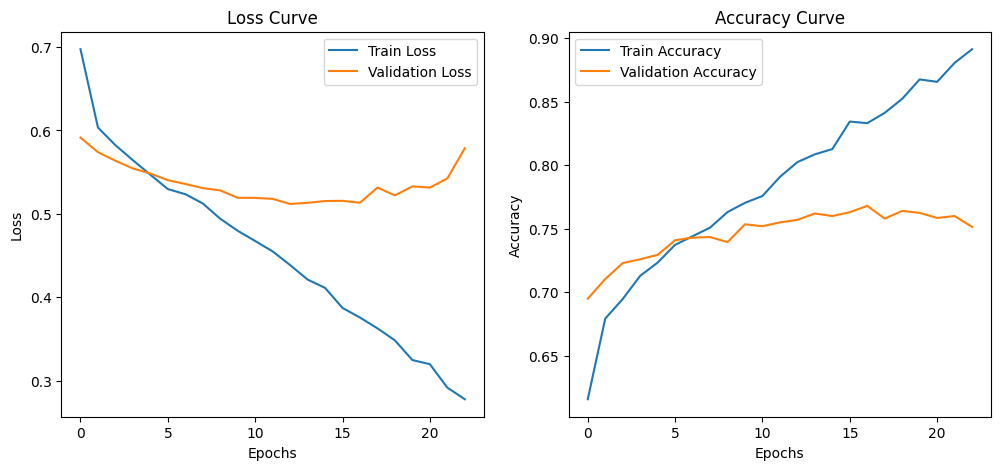

-------Model 3-------


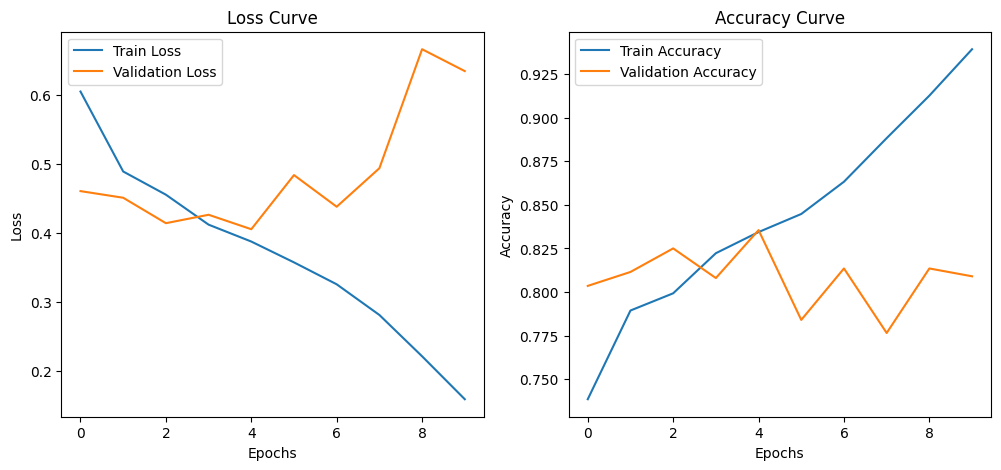

In [23]:
print("-------Model 1-------")
graph_train_hist(history1)
print("-------Model 2-------")
graph_train_hist(history2)
print("-------Model 3-------")
graph_train_hist(history3)

## Conclusion

## Submission Results and Analysis

| Submission | Private Score | Public Score | Difference (Private - Public) |
|------------|--------------|--------------|--------------------------------|
| v3(3)      | 0.8888       | 0.8710       | +0.0178                        |
| v3(2)      | 0.8329       | 0.8801       | -0.0472                        |
| v3(1)      | 0.8316       | 0.8585       | -0.0269                        |
| model 3    | 0.8595       | 0.8908       | -0.0313                        |
| model 2    | 0.7880       | 0.8418       | -0.0538                        |
| model 1    | 0.8300       | 0.9009       | -0.0709                        |

### Analysis and Findings

#### **Best Private Score**
- **v3(3)** achieved the highest Private Score (0.8888), which is higher than the Public Score (0.8710).
- This indicates good generalization ability, as the model performs more stably on the hidden test set.

#### **Highest Public Score but Largest Private Score Drop**
- **model 1** had the highest Public Score (0.9009), but its Private Score (0.8300) dropped significantly (-0.0709).
- This suggests that the model may have overfitted to the Public Test Set, leading to poorer performance on the Private Test Set.

#### **Largest Differences (Signs of Overfitting)**
- **model 1 (-0.0709) and model 2 (-0.0538)** had significantly lower Private Scores compared to their Public Scores.
- This indicates that these models performed better on the Public Test Set but had weaker generalization ability on the Private Test Set.

#### **Most Stable Models**
- **v3(3) and v3(1)** had the smallest differences between Private and Public Scores (+0.0178 and -0.0269).
- This suggests that these models performed consistently across different test sets and had better generalization ability.